In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../..")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from ycbv_loader import YCBVDataset

In [2]:
class YCBVConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'ycb'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1 + 21
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    TRAIN_ROIS_PER_IMAGE = 100
    STEPS_PER_EPOCH = 100
    VALIDATION_STEPS = 5
    
config = YCBVConfig()
# config.display()

In [3]:
data_dir = os.path.join(ROOT_DIR, 'randomized_data')
dataset_train = YCBVDataset(data_dir, split='train')
dataset_train.load_ycbv()
dataset_train.prepare()

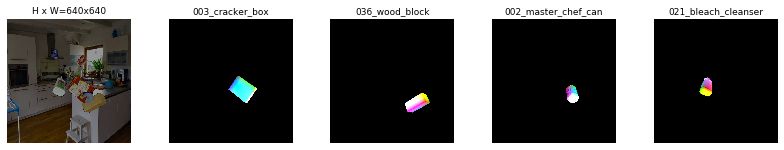

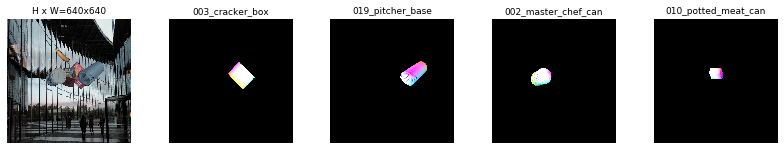

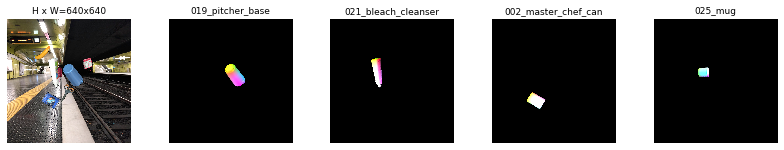

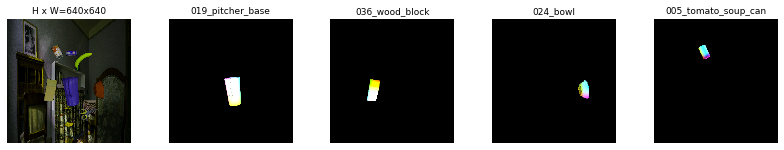

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    masks, class_ids = dataset_train.load_rgb_mask(image_id)
    visualize.display_rgb_top_masks(image, masks, class_ids, dataset_train.class_names)

image                    shape: (640, 640, 3)         min:    0.00000  max:  234.00000  uint8
mask                     shape: (640, 640, 3, 7)      min:    0.00000  max:  255.00000  uint8
class_ids                shape: (7,)                  min:    1.00000  max:   21.00000  int32
bbox                     shape: (7, 4)                min:  149.00000  max:  568.00000  int32


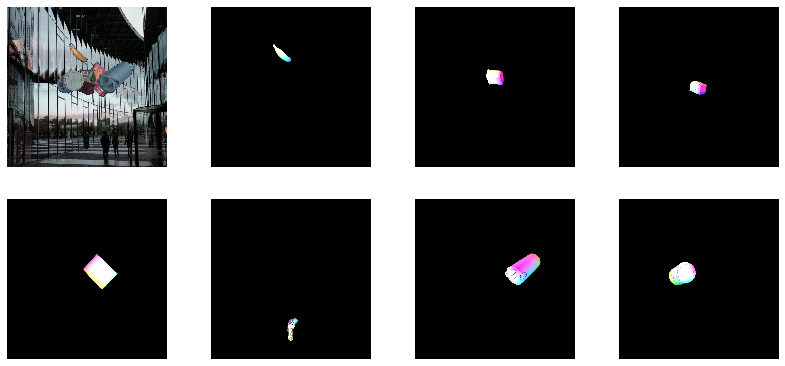

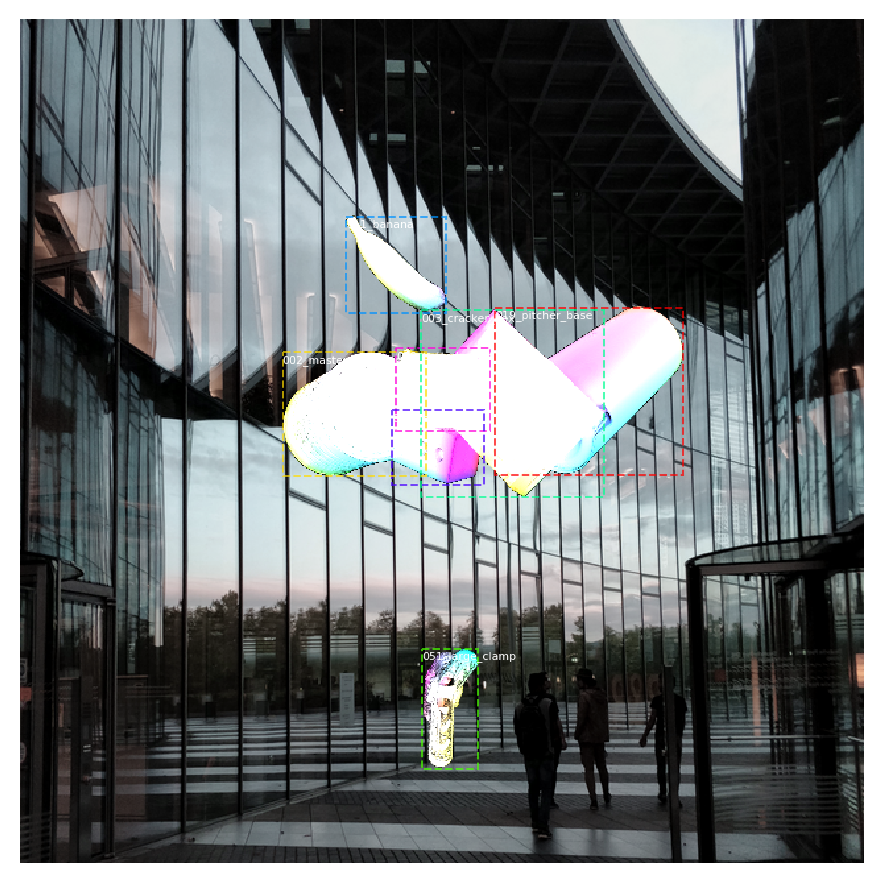

In [8]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image, _, class_id, bbox, mask = modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
# image = dataset_train.load_image(image_id)
# mask, class_ids = dataset_train.load_rgb_mask(image_id)
# Compute Bounding box
# bbox = utils.extract_bboxes(mask)
# Display image and additional stats
log("image", image)
log("mask", mask)
log("class_ids", class_id)
log("bbox", bbox)
# print(mask.shape)
# mini_mask = cv2.resize(mask, config.MINI_MASK_SHAPE)
# print(mini_mask.shape)
# print(mask.shape)
mini_mask = utils.minimize_rgb_mask(bbox, mask, config.MINI_MASK_SHAPE)
# print(mini_mask.shape)
# visualize.display_images([image]+[mini_mask])
visualize.display_images([image]+[mask[:, :, :, i] for i in range(mask.shape[-1])])
visualize.display_rgb_instances(image, bbox, mask, class_id, dataset_train.class_names)